In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv, GraphConv
from torch_geometric.nn.norm import BatchNorm
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import itertools
from math import radians, sin, cos, sqrt, atan2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <div align="center">**ZE EPIC DATA**</div>

In [2]:
# Directory containing the CSV files
directory = '../processed-final-data'

# Dictionary to store the dataframes
dataframes = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Extract the file name without extension and convert it to int
        key = int(os.path.splitext(filename)[0])
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes[key] = df


# Print the dictionary keys to verify
print(dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [ ]:
# Dictionaries to store the training and testing dataframes
train_dataframes = {}
test_dataframes = {}

# Split each dataframe into training and testing sets
for key, df in dataframes.items():
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    train_dataframes[key] = train_df
    test_dataframes[key] = test_df
    # Check if the maximum index of the training set is less than the minimum index of the testing set
    if train_df.index.max() < test_df.index.min():
        print(f"{key}: Sequential split verified.")
    else:
        print(f"{key}: Sequential split NOT verified.")

# Print the keys of the training and testing dictionaries to verify
print(train_dataframes.keys())
print(test_dataframes.keys())

72790024141: Sequential split verified.
72785524114: Sequential split verified.
72789094197: Sequential split verified.
72793024233: Sequential split verified.
72785794129: Sequential split verified.
72788594266: Sequential split verified.
72797624217: Sequential split verified.
72785024157: Sequential split verified.
72797094240: Sequential split verified.
72798594276: Sequential split verified.
72792424223: Sequential split verified.
72792894263: Sequential split verified.
72781024243: Sequential split verified.
72781524237: Sequential split verified.
72788324220: Sequential split verified.
72698824219: Sequential split verified.
72793894274: Sequential split verified.
74206024207: Sequential split verified.
72782724110: Sequential split verified.
72793724222: Sequential split verified.
72792594227: Sequential split verified.
72782594239: Sequential split verified.
72794504205: Sequential split verified.
72792394225: Sequential split verified.
72784524163: Sequential split verified.


In [4]:
def create_node_features_sequences(dataframes):
    # Create a list to store the node features for each time step for input and desired output
    node_features_sequence_input = []
    node_features_sequence_output = []

    # Iterate over the rows of the dataframes (assuming all dataframes have the same number of rows)
    for i in range(len(next(iter(dataframes.values())))):
        if i == len(next(iter(dataframes.values()))) - 1:
            break
        # Create a list to store the features of all nodes at the current time step for input
        node_features_input = []
        # Create a list to store the features of all nodes at the next time step for output
        node_features_output = []

        # Iterate over each dataframe and extract the features at the current row for input
        # and the next row for output
        for key, df in dataframes.items():
            node_features_input.append(df.iloc[i].values)
            node_features_output.append(df.iloc[i + 1].drop(['DayOfYear_sin', 'DayOfYear_cos']).values)

        # Stack the features of all nodes to create a 2D array (num_nodes, num_features)
        node_features_sequence_input.append(np.stack(node_features_input))
        node_features_sequence_output.append(np.stack(node_features_output))

    # Convert the lists to numpy arrays (time_steps, num_nodes, num_features)
    node_features_sequence_input = np.array(node_features_sequence_input)
    node_features_sequence_output = np.array(node_features_sequence_output)

    # Convert the numpy arrays to torch tensors
    node_features_sequence_input = torch.tensor(node_features_sequence_input, dtype=torch.float)
    node_features_sequence_output = torch.tensor(node_features_sequence_output, dtype=torch.float)

    return node_features_sequence_input, node_features_sequence_output

# Call the function and print the shapes of the resulting tensors
node_features_sequence_input_train, node_features_sequence_output_train = create_node_features_sequences(train_dataframes)
node_features_sequence_input_test, node_features_sequence_output_test = create_node_features_sequences(test_dataframes)
np.set_printoptions(suppress=True, precision=4)
torch.set_printoptions(sci_mode=False, precision=4)

print(node_features_sequence_input_train.shape)
print(node_features_sequence_output_test.shape)
print(node_features_sequence_input_train[0])
print(node_features_sequence_output_train[0])

torch.Size([1408, 27, 69])
torch.Size([352, 27, 67])
tensor([[    0.0172,     0.9999,    34.5600,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0172,     0.9999,    37.9706,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0172,     0.9999,    31.8846,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0172,     0.9999,    37.8750,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0172,     0.9999,    44.3333,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0172,     0.9999,    34.9310,  ...,     0.0000,     0.0000,
             0.0000]])
tensor([[30.0000, 37.8485, 76.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.4688, 34.1875, 84.7500,  ...,  0.0000,  0.0000,  0.0000],
        [26.5385, 38.6923, 63.0769,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [36.7083, 46.0833, 61.0000,  ...,  0.0000,  0.0000,  0.0000],
        [41.2553, 43.7660, 90.9362,  ...,  0.0000,  0.0000

# <div align="center">**ZE EPIC EDGE DATA**</div>

In [5]:
# Import the location-datamap.csv file as a dataframe
location_datamap_df = pd.read_csv('../location-datamap.csv')

# Print the first few rows of the dataframe to verify
print(location_datamap_df.head())

        STATION  LONGITUDE  LATITUDE  ELEVATION
0  7.279002e+10 -119.51551  47.30777      382.1
1  7.278552e+10 -117.65000  47.63333      750.1
2  7.278909e+10 -119.52091  48.46113      397.4
3  7.279302e+10 -122.31442  47.44467      112.5
4  7.278579e+10 -117.11581  46.74376      775.7


In [6]:
def haversine_distance(lat1, lon1, lat2, lon2, el1=0, el2=0):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    # Elevation difference
    height = el2 - el1

    # Calculate the total distance considering elevation
    total_distance = sqrt(distance**2 + height**2)

    return total_distance

In [ ]:
def create_edge_index(dataframes):
    edges = []
    edges_verifications = []
    keys = list(dataframes.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            if i != j:
                edges.append(([i, j]))
                edges.append(([j, i]))
                edges_verifications.append(([keys[i],keys[j],i, j]))
                edges_verifications.append(([keys[j],keys[i],j, i]))
    display(edges_verifications)
    return edges

edge_index = create_edge_index(dataframes)
display(edge_index)        

[[72790024141, 72785524114, 0, 1],
 [72785524114, 72790024141, 1, 0],
 [72790024141, 72789094197, 0, 2],
 [72789094197, 72790024141, 2, 0],
 [72790024141, 72793024233, 0, 3],
 [72793024233, 72790024141, 3, 0],
 [72790024141, 72785794129, 0, 4],
 [72785794129, 72790024141, 4, 0],
 [72790024141, 72788594266, 0, 5],
 [72788594266, 72790024141, 5, 0],
 [72790024141, 72797624217, 0, 6],
 [72797624217, 72790024141, 6, 0],
 [72790024141, 72785024157, 0, 7],
 [72785024157, 72790024141, 7, 0],
 [72790024141, 72797094240, 0, 8],
 [72797094240, 72790024141, 8, 0],
 [72790024141, 72798594276, 0, 9],
 [72798594276, 72790024141, 9, 0],
 [72790024141, 72792424223, 0, 10],
 [72792424223, 72790024141, 10, 0],
 [72790024141, 72792894263, 0, 11],
 [72792894263, 72790024141, 11, 0],
 [72790024141, 72781024243, 0, 12],
 [72781024243, 72790024141, 12, 0],
 [72790024141, 72781524237, 0, 13],
 [72781524237, 72790024141, 13, 0],
 [72790024141, 72788324220, 0, 14],
 [72788324220, 72790024141, 14, 0],
 [72790024

[[0, 1],
 [1, 0],
 [0, 2],
 [2, 0],
 [0, 3],
 [3, 0],
 [0, 4],
 [4, 0],
 [0, 5],
 [5, 0],
 [0, 6],
 [6, 0],
 [0, 7],
 [7, 0],
 [0, 8],
 [8, 0],
 [0, 9],
 [9, 0],
 [0, 10],
 [10, 0],
 [0, 11],
 [11, 0],
 [0, 12],
 [12, 0],
 [0, 13],
 [13, 0],
 [0, 14],
 [14, 0],
 [0, 15],
 [15, 0],
 [0, 16],
 [16, 0],
 [0, 17],
 [17, 0],
 [0, 18],
 [18, 0],
 [0, 19],
 [19, 0],
 [0, 20],
 [20, 0],
 [0, 21],
 [21, 0],
 [0, 22],
 [22, 0],
 [0, 23],
 [23, 0],
 [0, 24],
 [24, 0],
 [0, 25],
 [25, 0],
 [0, 26],
 [26, 0],
 [1, 2],
 [2, 1],
 [1, 3],
 [3, 1],
 [1, 4],
 [4, 1],
 [1, 5],
 [5, 1],
 [1, 6],
 [6, 1],
 [1, 7],
 [7, 1],
 [1, 8],
 [8, 1],
 [1, 9],
 [9, 1],
 [1, 10],
 [10, 1],
 [1, 11],
 [11, 1],
 [1, 12],
 [12, 1],
 [1, 13],
 [13, 1],
 [1, 14],
 [14, 1],
 [1, 15],
 [15, 1],
 [1, 16],
 [16, 1],
 [1, 17],
 [17, 1],
 [1, 18],
 [18, 1],
 [1, 19],
 [19, 1],
 [1, 20],
 [20, 1],
 [1, 21],
 [21, 1],
 [1, 22],
 [22, 1],
 [1, 23],
 [23, 1],
 [1, 24],
 [24, 1],
 [1, 25],
 [25, 1],
 [1, 26],
 [26, 1],
 [2, 3],
 [3, 

In [8]:
def create_edge_attributes(dataframes, location_datamap_df, edge_index):
    edge_attr = []
    edge_attr_verifications = []
    keys = list(dataframes.keys())
    for i, j in edge_index:
        station_i = location_datamap_df[location_datamap_df['STATION'] == keys[i]]
        station_j = location_datamap_df[location_datamap_df['STATION'] == keys[j]]
        lati, loni, eli = station_i['LATITUDE'].values[0], station_i['LONGITUDE'].values[0], station_i['ELEVATION'].values[0]
        latj, lonj, elj = station_j['LATITUDE'].values[0], station_j['LONGITUDE'].values[0], station_j['ELEVATION'].values[0]
        edge_attr_verifications.append(([keys[i], keys[j], i, j, haversine_distance(lati, loni, latj, lonj, eli, elj)]))
        edge_attr.append(haversine_distance(lati, loni, latj, lonj, eli, elj))
    display(edge_attr_verifications)
    return edge_attr

edge_attr = create_edge_attributes(dataframes, location_datamap_df, edge_index)
display(edge_attr)



[[72790024141, 72785524114, 0, 1, 395.4679457314314],
 [72785524114, 72790024141, 1, 0, 395.4679457314314],
 [72790024141, 72789094197, 0, 2, 129.15783117310457],
 [72789094197, 72790024141, 2, 0, 129.15783117310457],
 [72790024141, 72793024233, 0, 3, 342.5330553210191],
 [72793024233, 72790024141, 3, 0, 342.5330553210191],
 [72790024141, 72785794129, 0, 4, 438.10430559873856],
 [72785794129, 72790024141, 4, 0, 438.10430559873856],
 [72790024141, 72788594266, 0, 5, 432.0504921333856],
 [72788594266, 72790024141, 5, 0, 432.0504921333856],
 [72790024141, 72797624217, 0, 6, 437.11321302131137],
 [72797624217, 72790024141, 6, 0, 437.11321302131137],
 [72790024141, 72785024157, 0, 7, 369.0087247919059],
 [72785024157, 72790024141, 7, 0, 369.0087247919059],
 [72790024141, 72797094240, 0, 8, 503.7031148557305],
 [72797094240, 72790024141, 8, 0, 503.7031148557305],
 [72790024141, 72798594276, 0, 9, 455.6811328123654],
 [72798594276, 72790024141, 9, 0, 455.6811328123654],
 [72790024141, 7279242

[395.4679457314314,
 395.4679457314314,
 129.15783117310457,
 129.15783117310457,
 342.5330553210191,
 342.5330553210191,
 438.10430559873856,
 438.10430559873856,
 432.0504921333856,
 432.0504921333856,
 437.11321302131137,
 437.11321302131137,
 369.0087247919059,
 369.0087247919059,
 503.7031148557305,
 503.7031148557305,
 455.6811328123654,
 455.6811328123654,
 474.59654599988056,
 474.59654599988056,
 348.0950737502581,
 348.0950737502581,
 128.6980383337319,
 128.6980383337319,
 835.9738346074198,
 835.9738346074198,
 171.59537540199554,
 171.59537540199554,
 384.56540064951065,
 384.56540064951065,
 373.58764051749137,
 373.58764051749137,
 362.1843030623904,
 362.1843030623904,
 32.53657446575969,
 32.53657446575969,
 306.4908073667999,
 306.4908073667999,
 404.50991220772727,
 404.50991220772727,
 52.81240627430448,
 52.81240627430448,
 404.8085057270694,
 404.8085057270694,
 505.4288197147213,
 505.4288197147213,
 286.0836462058196,
 286.0836462058196,
 412.6227567328569,
 412

In [9]:
# Convert edge_index to a torch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Print the shape to verify
print(edge_index.shape)
print(edge_index)

torch.Size([2, 702])
tensor([[ 0,  1,  0,  ..., 26, 25, 26],
        [ 1,  0,  2,  ..., 24, 26, 25]])


In [10]:
# Convert edge_attr to a torch tensor
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

# Min-Max normalization to scale the values to the range [0, 1]
edge_attr_min = edge_attr_tensor.min()
edge_attr_max = edge_attr_tensor.max()
edge_attr = (edge_attr_tensor - edge_attr_min) / (edge_attr_max - edge_attr_min)

# Print the normalized edge_attr tensor to verify
print(edge_attr.shape)
print(edge_attr)


torch.Size([702])
tensor([0.3146, 0.3146, 0.0928, 0.0928, 0.2705, 0.2705, 0.3501, 0.3501, 0.3450,
        0.3450, 0.3492, 0.3492, 0.2925, 0.2925, 0.4047, 0.4047, 0.3647, 0.3647,
        0.3805, 0.3805, 0.2751, 0.2751, 0.0924, 0.0924, 0.6814, 0.6814, 0.1281,
        0.1281, 0.3055, 0.3055, 0.2963, 0.2963, 0.2869, 0.2869, 0.0123, 0.0123,
        0.2405, 0.2405, 0.3221, 0.3221, 0.0292, 0.0292, 0.3223, 0.3223, 0.4061,
        0.4061, 0.2235, 0.2235, 0.3289, 0.3289, 0.2119, 0.2119, 0.3101, 0.3101,
        0.5912, 0.5912, 0.0767, 0.0767, 0.6506, 0.6506, 0.6535, 0.6535, 0.0133,
        0.0133, 0.7057, 0.7057, 0.6728, 0.6728, 0.7020, 0.7020, 0.5890, 0.5890,
        0.3982, 0.3982, 0.4313, 0.4313, 0.2472, 0.2472, 0.6211, 0.6211, 0.6176,
        0.6176, 0.6086, 0.6086, 0.3318, 0.3318, 0.5505, 0.5505, 0.6388, 0.6388,
        0.3348, 0.3348, 0.6399, 0.6399, 0.7233, 0.7233, 0.5312, 0.5312, 0.6500,
        0.6500, 0.1164, 0.1164, 0.2937, 0.2937, 0.3687, 0.3687, 0.3454, 0.3454,
        0.3328, 0.3328

# <div align="center">**ZE EPIC GPU IMPORT**</div>

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Move data to device
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

# <div align="center">**ZE EPIC BATCHING**</div>

In [13]:
batch_size = node_features_sequence_input_train.shape[0] // 8 # Adjust this value based on your GPU memory capacity
# Calculate the number of full batches
num_full_batches_train = (node_features_sequence_input_train.size(0) // batch_size) * batch_size

# Trim the input and output tensors to have a size divisible by the batch size
trimmed_input_train = node_features_sequence_input_train[:num_full_batches_train]
trimmed_output_train = node_features_sequence_output_train[:num_full_batches_train]

# Create batches of data
batched_input_train = trimmed_input_train.view(-1, batch_size, trimmed_input_train.size(1), trimmed_input_train.size(2))
batched_output_train = trimmed_output_train.view(-1, batch_size, trimmed_output_train.size(1), trimmed_output_train.size(2))

# Adjust the number of batches
num_batches_train = batched_input_train.size(0)

# Print the batch size and number of full batches to verify
print("Batch size:", batch_size)
print("Number of full batches:", num_full_batches_train)

print("Batched input train dimensionality:", batched_input_train.shape)
print("Batched output train dimensionality:", batched_output_train.shape)
print("Batched input train dimensionality:", batched_input_train[0].shape)
print("Batched output train dimensionality:", batched_output_train[0].shape)

# Check for NaN or Inf in input data
assert not torch.isnan(batched_input_train).any(), "NaN values found in batched_input_train"
assert not torch.isinf(batched_input_train).any(), "Inf values found in batched_input_train"

# Check for NaN or Inf in output data
assert not torch.isnan(batched_output_train).any(), "NaN values found in batched_output_train"
assert not torch.isinf(batched_output_train).any(), "Inf values found in batched_output_train"

Batch size: 176
Number of full batches: 1408
Batched input train dimensionality: torch.Size([8, 176, 27, 69])
Batched output train dimensionality: torch.Size([8, 176, 27, 67])
Batched input train dimensionality: torch.Size([176, 27, 69])
Batched output train dimensionality: torch.Size([176, 27, 67])


In [14]:
batch_size = node_features_sequence_input_test.shape[0] // 4# Adjust this value based on your GPU memory capacity
# Calculate the number of full batches
num_full_batches_test = (node_features_sequence_input_test.size(0) // batch_size) * batch_size

# Trim the input and output tensors to have a size divisible by the batch size
trimmed_input_test = node_features_sequence_input_test[:num_full_batches_test]
trimmed_output_test = node_features_sequence_output_test[:num_full_batches_test]

# Create batches of data
batched_input_test = trimmed_input_test.view(-1, batch_size, trimmed_input_test.size(1), trimmed_input_test.size(2))
batched_output_test = trimmed_output_test.view(-1, batch_size, trimmed_output_test.size(1), trimmed_output_test.size(2))

# Adjust the number of batches
num_batches_test = batched_input_test.size(0)
print("Batch size:", batch_size)
print("Number of full batches:", num_full_batches_train)

print("Batched input test dimensionality:", batched_input_test.shape)
print("Batched output test dimensionality:", batched_output_test.shape)


Batch size: 88
Number of full batches: 1408
Batched input test dimensionality: torch.Size([4, 88, 27, 69])
Batched output test dimensionality: torch.Size([4, 88, 27, 67])


# <div align="center">**ZE EPIC MODEL**</div>

In [15]:
# Transformer model for the hybrid model
# Input Dimension: [batch_length ,num_nodes, num_features]
# Output Dimension: [batch_length, num_nodes, hidden_channels]
class TransformerModule(nn.Module):
    def __init__(self, features_channels, out_channels, transformer_layers):
        super(TransformerModule, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=features_channels, nhead=features_channels, batch_first=True),
            num_layers=transformer_layers
        )
        self.output_linear = nn.Linear(features_channels, out_channels)

    def forward(self, x):
        temporal_outputs = self.transformer_encoder(x)  # Shape: [num_timesteps, num_nodes, hidden_channels]
        x = self.output_linear(temporal_outputs)  # Shape: [num_timesteps, num_nodes, out_channels]
        return x

In [16]:
# GNN module for the hybrid model
# Input Dimension: [batch_length ,num_nodes, num_features]
# Output Dimension: [batch_length, num_nodes, hidden_channels]
class GNNModule(torch.nn.Module):
    def __init__(self, features_channels, hidden_channels, edge_in_channels):
        super(GNNModule, self).__init__()
        self.conv1 = GATv2Conv(features_channels, hidden_channels, edge_dim=edge_in_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.batch_norm1 = BatchNorm(hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.batch_norm3 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def gnn_forward(self, x, edge_index, edge_attr):

        # print("input",x.shape)
        # print(torch.isnan(x).any())
        # print(torch.isinf(x).any())

        edge_weight = 1.0 / (edge_attr + 1e-6)
        x1 = self.conv1(x, edge_index, edge_attr=edge_weight)
        x1 = self.batch_norm1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)

        # print("Gat",x1.shape)
        # print(torch.isnan(x1).any())
        # print(torch.isinf(x1).any())

        x2 = self.conv2(x1, edge_index, edge_weight=edge_attr)
        x2 = self.batch_norm2(x2)
        x2 = F.relu(x2)        
        x2 = self.dropout(x2)

        # print("gnc",x2.shape)
        # print(torch.isnan(x2).any())
        # print(torch.isinf(x2).any())

        x3 = self.conv3(x2, edge_index)
        x3 = self.batch_norm3(x3)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)

        # print("graph",x3.shape)
        # print(torch.isnan(x3).any())
        # print(torch.isinf(x3).any())

        x = x1 + x2 + x3  # Residual connection

        # print("residual",x.shape)
        # print(torch.isnan(x).any())
        # print(torch.isinf(x).any())

        return x  # Shape: [num_nodes, hidden_channels]

    def forward(self, x, edge_index, edge_attr):
        spatial_outputs = []
        for t in range(x.size(0)):
            x_t = self.gnn_forward(x[t], edge_index, edge_attr)
            spatial_outputs.append(x_t)

        x = torch.stack(spatial_outputs, dim=0)  # Shape: [num_timesteps, num_nodes, hidden_channels]
        
        return x

In [17]:
# Hybrid model combining the Transformer and GNN modules
# Input Dimension: [batch_length ,num_nodes, num_features]
# Output Dimension: [batch_length, num_nodes, out_channels]
class HybridModel_Transformer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers):
        super(HybridModel_Transformer, self).__init__()
        self.transformer = TransformerModule(features_channels, hidden_channels, transformer_layers)
        self.gnn = GNNModule(hidden_channels, hidden_channels, edge_in_channels)
        self.output_layer = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Project the input features to the hidden dimension
        # Transform the input features using the transformer
        x = self.transformer(x)

        # print("transformer forward",x.shape)
        # print(torch.isnan(x).any())
        # print(torch.isinf(x).any())

        # Pass the transformed features to the GNN
        x = self.gnn(x, edge_index, edge_attr)

        # print("gnn",x.shape)
        # print(torch.isnan(x).any())
        # print(torch.isinf(x).any())

        # Pass the GNN outputs through a linear layer
        x = self.output_layer(x)
        return x

In [18]:
class HybridModel_GNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers):
        super(HybridModel_GNN, self).__init__()
        self.gnn = GNNModule(features_channels, hidden_channels, edge_in_channels)
        self.transformer = TransformerModule(hidden_channels, out_channels, transformer_layers)

    def forward(self, x, edge_index, edge_attr):
        # Apply GNN first
        x = self.gnn(x, edge_index, edge_attr)

        # Apply transformer
        x = self.transformer(x)
        return x 

In [19]:
class HybridModel_Parallel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers):
        super(HybridModel_Parallel, self).__init__()
        self.gnn = GNNModule(features_channels, hidden_channels, edge_in_channels)
        self.transformer = TransformerModule(features_channels, hidden_channels, transformer_layers)
        self.output_layer = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Project the input features to the hidden dimension
        # Transform the input features using the transformer
        x_gnn = self.gnn(x, edge_index, edge_attr)
        x_transformer = self.transformer(x)

        # Pass the transformed features to the GNN
        x = x_gnn + x_transformer

        # Pass the GNN outputs through a linear layer
        x = self.output_layer(x)

        
        return x
        

In [20]:
class SingleModel_Transformer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers):
        super(SingleModel_Transformer, self).__init__()
        self.transformer = TransformerModule(features_channels, out_channels, transformer_layers)

    def forward(self, x, edge_index, edge_attr):
        # Project the input features to the hidden dimension
        # Transform the input features using the transformer
        x = self.transformer(x)
        return x

In [21]:
class SingleModel_GNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers):
        super(SingleModel_GNN, self).__init__()
        self.gnn = GNNModule(features_channels, hidden_channels, edge_in_channels)
        self.output_layer = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Apply GNN first
        x = self.gnn(x, edge_index, edge_attr)

        # Apply transformer
        x = self.output_layer(x)
        return x

# <div align="center">**ZE EPIC MODEL TRAIN**</div>

In [22]:
def train_model(model, optimizer, scheduler, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device):
    epoch_losses = []
    epoch_maes = []

    # Set the model to training mode
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_mae = 0

        optimizer.zero_grad()

        for b in range(num_batches_train):
            # Get the batched node features and desired output
            node_features_batch = batched_input_train[b].to(device)
            desired_output_batch = batched_output_train[b].to(device)

            # print("Node features batch: ", node_features_batch.shape)
            # print(torch.isnan(node_features_batch).any())
            # print(torch.isinf(node_features_batch).any())
            # Forward pass with batch_size parameter

            model_output_batch = model(node_features_batch, edge_index, edge_attr)
            
            # print("Model be outputing: ", model_output_batch.shape)
            # print(torch.isnan(model_output_batch).any())
            # print(torch.isinf(model_output_batch).any())

            # print("Desired output: ", desired_output_batch.shape)
            # print(torch.isnan(desired_output_batch).any())
            # print(torch.isinf(desired_output_batch).any())

            # Compute loss
            loss = loss_fn(model_output_batch, desired_output_batch)

            # Backward pass
            loss.backward()
            
            # Update the optimizer
            optimizer.step()
            optimizer.zero_grad()

            # Compute MAE for debugging
            mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))

            total_loss += loss.item()
            total_mae += mae.item()

        average_loss = total_loss / num_batches_train
        average_mae = total_mae / num_batches_train
        epoch_losses.append(average_loss)
        epoch_maes.append(average_mae)

        scheduler.step(average_loss)

        current_lr = optimizer.param_groups[0]['lr']
        current_patience = scheduler.num_bad_epochs
        print(f"Epoch {epoch+1}, Average Loss: {average_loss}, Average MAE: {average_mae}, Learning Rate: {current_lr}, Current Patience: {current_patience}")
        torch.cuda.empty_cache()

    return epoch_losses, epoch_maes


In [23]:
# Define the parameters
num_epochs = 200  # Adjust the number of epochs as needed
learning_rate = 0.01
scheduler_mode = 'min'
scheduler_factor = 0.8
scheduler_patience = 5

#Print all parameter 
print("Number of epochs:", num_epochs)
print("Learning rate:", learning_rate)
print("Scheduler mode:", scheduler_mode)
print("Scheduler factor:", scheduler_factor)
print("Scheduler patience:", scheduler_patience)

# Define the loss function
loss_fn = torch.nn.MSELoss()

Number of epochs: 200
Learning rate: 0.01
Scheduler mode: min
Scheduler factor: 0.8
Scheduler patience: 5


In [24]:
# Model Train Toggle
new_iteration = True

run_model_parallel = True
run_model_transformer_gnn = True
run_model_gnn_transformer = True
run_model_single_transformer = True
run_model_single_gnn = True
run_plotting = True

hidden_channels = 1024
transformer_layers = 8

In [25]:
from datetime import datetime

def save_model_data(model, optimizer, scheduler, epoch_losses, epoch_maes, hidden_channels, transformer_layers, new_iteration, model_name):
    # Create the directory if it doesn't exist
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    current_date = datetime.now().strftime('%Y%m%d')
    parent_dir = f'saved_models{current_date}'
    # Find the number of existing folders with the prefix
    existing_folders = [d for d in os.listdir('.') if d.startswith(f'saved_models_{current_date}')]
    folder_num = len(existing_folders)
    if (new_iteration):
        folder_num = folder_num + 1
        new_iteration = False
    folder_path = f'saved_models_{current_date}_3/{model_name}_{current_time}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the model, optimizer, and scheduler states
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'hidden_channels': hidden_channels,
        'transformer_layers': transformer_layers
    }, os.path.join(folder_path, f'{model_name}.pt'))

    # Save epoch losses and MAEs to a CSV file
    df = pd.DataFrame({
        'epoch': range(1, len(epoch_losses) + 1),
        'loss': epoch_losses,
        'mae': epoch_maes
    })
    df.to_csv(os.path.join(folder_path, f'{model_name}_metrics.csv'), index=False)
    print(f"Model data saved in {folder_path}")

In [26]:

if run_model_parallel:
    # Call the function
    # Define the parameters
    in_channels = batched_input_train.shape[2]
    features_channels = batched_input_train.shape[3]
    out_channels = batched_output_train.shape[3]
    edge_in_channels = 1

    # Print the parameters to verify
    print("Input Channels:", in_channels)
    print("Features Channels:", features_channels)
    print("Output Channels:", out_channels)
    print("Edge Input Channels:", edge_in_channels)
    print("Hidden Channels:", hidden_channels)
    print("Transformer Layers:", transformer_layers)

    model_parallel = HybridModel_Parallel(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)

    # Define the optimizer and loss function for model_parallel
    optimizer_parallel = torch.optim.Adam(model_parallel.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler_parallel = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_parallel, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=1e-5)

    parallel_epoch_losses, parallel_epoch_maes = train_model(model_parallel, optimizer_parallel, scheduler_parallel, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device)
    save_model_data(model_parallel, optimizer_parallel, scheduler_parallel, parallel_epoch_losses, parallel_epoch_maes, hidden_channels, transformer_layers,new_iteration, 'model_parallel')
    del model_parallel

    torch.cuda.empty_cache()

Input Channels: 27
Features Channels: 69
Output Channels: 67
Edge Input Channels: 1
Hidden Channels: 1024
Transformer Layers: 8


/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Average Loss: 97.2294774055481, Average MAE: 6.05114221572876, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 28.19705581665039, Average MAE: 3.301598012447357, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 20.608396530151367, Average MAE: 2.1070550233125687, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 16.793187499046326, Average MAE: 1.8312254399061203, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 14.940422654151917, Average MAE: 1.5427388399839401, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 13.894131660461426, Average MAE: 1.3755286186933517, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 13.36318850517273, Average MAE: 1.3104499131441116, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 12.897597670555115, Average MAE: 1.259735181927681, Learning Rate: 0.01, Current Patience: 0
Epoch 9, Average Loss: 12.51944637298584, Average MAE: 1.217210426926612

In [27]:
# Toggle to run the code
if run_model_transformer_gnn:
    # Call the function
    # Define the parameters
    in_channels = batched_input_train.shape[2]
    features_channels = batched_input_train.shape[3]
    out_channels = batched_output_train.shape[3]  
    edge_in_channels = 1

    # Print the parameters to verify
    print("Input Channels:", in_channels)
    print("Features Channels:", features_channels)
    print("Output Channels:", out_channels)
    print("Edge Input Channels:", edge_in_channels)
    print("Hidden Channels:", hidden_channels)
    print("Transformer Layers:", transformer_layers)

    model_transformer_gnn = HybridModel_Transformer(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)

    # Define the optimizer and loss function for model_transformer_gnn
    optimizer_transformer_gnn = torch.optim.Adam(model_transformer_gnn.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler_transformer_gnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_transformer_gnn, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=1e-5)

    transformer_gnn_epoch_losses, transformer_gnn_epoch_maes = train_model(model_transformer_gnn, optimizer_transformer_gnn, scheduler_transformer_gnn, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device)
    save_model_data(model_transformer_gnn, optimizer_transformer_gnn, scheduler_transformer_gnn, transformer_gnn_epoch_losses, transformer_gnn_epoch_maes, hidden_channels, transformer_layers, new_iteration, 'model_transformer_gnn')
    del model_transformer_gnn
    torch.cuda.empty_cache()

Input Channels: 27
Features Channels: 69
Output Channels: 67
Edge Input Channels: 1
Hidden Channels: 1024
Transformer Layers: 8
Epoch 1, Average Loss: 120.29445266723633, Average MAE: 6.562188476324081, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 46.203734159469604, Average MAE: 4.221675872802734, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 28.47173285484314, Average MAE: 2.9659784138202667, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 21.549693822860718, Average MAE: 2.255363807082176, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 19.067057609558105, Average MAE: 1.8566427528858185, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 17.006380081176758, Average MAE: 1.5501118004322052, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 15.940709352493286, Average MAE: 1.3787061423063278, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 15.257993936538696, Average MAE: 1

In [28]:
# Toggle to run the code
if run_model_gnn_transformer:
    # Define the parameters
    in_channels = batched_input_train.shape[2]
    features_channels = batched_input_train.shape[3]
    out_channels = batched_output_train.shape[3]  
    edge_in_channels = 1
    transformer_layers_gnn_transformer = 4

    # Print the parameters to verify
    print("Input Channels:", in_channels)
    print("Features Channels:", features_channels)
    print("Output Channels:", out_channels)
    print("Edge Input Channels:", edge_in_channels)
    print("Hidden Channels:", hidden_channels)
    print("Transformer Layers:", transformer_layers)

    model_gnn_transformer = HybridModel_GNN(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers_gnn_transformer).to(device)

    # Define the optimizer and loss function for model_gnn_transformer
    optimizer_gnn_transformer = torch.optim.Adam(model_gnn_transformer.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler_gnn_transformer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_gnn_transformer, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=1e-5)

    gnn_transformer_epoch_losses, gnn_transformer_epoch_maes = train_model(model_gnn_transformer, optimizer_gnn_transformer, scheduler_gnn_transformer, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device)
    save_model_data(model_gnn_transformer, optimizer_gnn_transformer, scheduler_gnn_transformer, gnn_transformer_epoch_losses, gnn_transformer_epoch_maes, hidden_channels, transformer_layers_gnn_transformer, new_iteration, 'model_gnn_transformer')
    del model_gnn_transformer
    torch.cuda.empty_cache()


Input Channels: 27
Features Channels: 69
Output Channels: 67
Edge Input Channels: 1
Hidden Channels: 1024
Transformer Layers: 8
Epoch 1, Average Loss: 96.6826844215393, Average MAE: 4.9285076558589935, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 27.552952527999878, Average MAE: 2.94597065448761, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 19.35744857788086, Average MAE: 2.0946617871522903, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 16.58505392074585, Average MAE: 1.6016438603401184, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 15.319072484970093, Average MAE: 1.333859845995903, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 14.795819282531738, Average MAE: 1.1632893830537796, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 14.43172001838684, Average MAE: 1.0723362863063812, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 14.443726062774658, Average MAE: 1.007

In [29]:
if run_model_single_transformer:
    # Define the parameters
    in_channels = batched_input_train.shape[2]
    features_channels = batched_input_train.shape[3]
    out_channels = batched_output_train.shape[3]  
    edge_in_channels = 1

    # Print the parameters to verify
    print("Input Channels:", in_channels)
    print("Features Channels:", features_channels)
    print("Output Channels:", out_channels)
    print("Edge Input Channels:", edge_in_channels)
    print("Hidden Channels:", hidden_channels)
    print("Transformer Layers:", transformer_layers)

    model_single_transformer = SingleModel_Transformer(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)

    # Define the optimizer and loss function for model_transformer
    optimizer_single_transformer = torch.optim.Adam(model_single_transformer.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler_single_transformer = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_single_transformer, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=1e-5)

    single_transformer_epoch_losses, single_transformer_epoch_maes = train_model(model_single_transformer, optimizer_single_transformer, scheduler_single_transformer, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device)
    save_model_data(model_single_transformer, optimizer_single_transformer, scheduler_single_transformer, single_transformer_epoch_losses, single_transformer_epoch_maes, hidden_channels, transformer_layers, new_iteration, 'model_single_transformer')
    del model_single_transformer
    torch.cuda.empty_cache()

Input Channels: 27
Features Channels: 69
Output Channels: 67
Edge Input Channels: 1
Hidden Channels: 1024
Transformer Layers: 8
Epoch 1, Average Loss: 197.56188774108887, Average MAE: 4.567760944366455, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 151.38161373138428, Average MAE: 3.8086769580841064, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 103.28258895874023, Average MAE: 2.9982439279556274, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 60.08474922180176, Average MAE: 2.0171632021665573, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 33.14969563484192, Average MAE: 1.452488273382187, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 21.423484325408936, Average MAE: 1.312433585524559, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 16.47177278995514, Average MAE: 1.0908333882689476, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 14.863280892372131, Average MAE: 1.0

TypeError: save_model_data() takes 9 positional arguments but 10 were given

Model data saved in saved_models_20241212_3/model_single_transformer_20241212_095315


In [31]:
if run_model_single_gnn:
    torch.cuda.empty_cache()
    # Define the parameters
    in_channels = batched_input_train.shape[2]
    features_channels = batched_input_train.shape[3]
    out_channels = batched_output_train.shape[3]  
    edge_in_channels = 1

    # Print the parameters to verify
    print("Input Channels:", in_channels)
    print("Features Channels:", features_channels)
    print("Output Channels:", out_channels)
    print("Edge Input Channels:", edge_in_channels)
    print("Hidden Channels:", hidden_channels)
    print("Transformer Layers:", transformer_layers)

    model_single_gnn = SingleModel_GNN(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    
    # Define the optimizer and loss function for model_gnn
    optimizer_single_gnn = torch.optim.Adam(model_single_gnn.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler_single_gnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_single_gnn, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True, min_lr=1e-5)

    single_gnn_epoch_losses, single_gnn_epoch_maes = train_model(model_single_gnn, optimizer_single_gnn, scheduler_single_gnn, loss_fn, num_epochs, num_batches_train, batched_input_train, batched_output_train, device)
    save_model_data(model_single_gnn, optimizer_single_gnn, scheduler_single_gnn, single_gnn_epoch_losses, single_gnn_epoch_maes, hidden_channels, transformer_layers, new_iteration, 'model_single_gnn')
    del model_single_gnn
    torch.cuda.empty_cache()


Input Channels: 27
Features Channels: 69
Output Channels: 67
Edge Input Channels: 1
Hidden Channels: 1024
Transformer Layers: 8
Epoch 1, Average Loss: 113.63659763336182, Average MAE: 6.514209181070328, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 37.94288778305054, Average MAE: 4.004881650209427, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 24.6147358417511, Average MAE: 2.810287758708, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 18.45980668067932, Average MAE: 2.13160440325737, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 16.09454321861267, Average MAE: 1.7292031198740005, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 14.58388340473175, Average MAE: 1.445575773715973, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 13.72382128238678, Average MAE: 1.2918961644172668, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 13.15995442867279, Average MAE: 1.204399690032

# <div align="center">**ZE EPIC GRAPHS**</div>

Shape of gnn_transformer_epoch_losses: (200,)
Shape of gnn_transformer_epoch_maes: (200,)
Shape of transformer_gnn_epoch_losses: (200,)
Shape of transformer_gnn_epoch_maes: (200,)
Shape of single_gnn_epoch_losses: (200,)
Shape of single_gnn_epoch_maes: (200,)
Shape of single_transformer_epoch_losses: (200,)
Shape of single_transformer_epoch_maes: (200,)
Shape of parallel_epoch_losses: (200,)
Shape of parallel_epoch_maes: (200,)


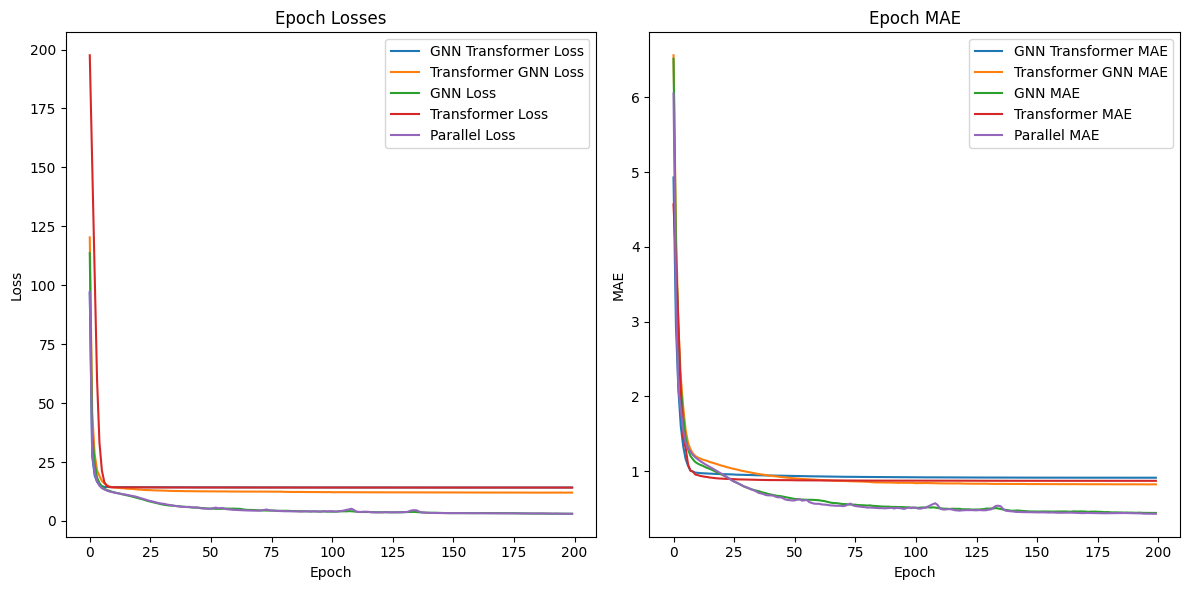

In [33]:


if run_plotting:
    # Print the shape of each variable
    print("Shape of gnn_transformer_epoch_losses:", np.shape(gnn_transformer_epoch_losses))
    print("Shape of gnn_transformer_epoch_maes:", np.shape(gnn_transformer_epoch_maes))
    print("Shape of transformer_gnn_epoch_losses:", np.shape(transformer_gnn_epoch_losses))
    print("Shape of transformer_gnn_epoch_maes:", np.shape(transformer_gnn_epoch_maes))
    print("Shape of single_gnn_epoch_losses:", np.shape(single_gnn_epoch_losses))
    print("Shape of single_gnn_epoch_maes:", np.shape(single_gnn_epoch_maes))
    print("Shape of single_transformer_epoch_losses:", np.shape(single_transformer_epoch_losses))
    print("Shape of single_transformer_epoch_maes:", np.shape(single_transformer_epoch_maes))
    print("Shape of parallel_epoch_losses:", np.shape(parallel_epoch_losses))
    print("Shape of parallel_epoch_maes:", np.shape(parallel_epoch_maes))

    # Flatten all arrays
    gnn_transformer_epoch_losses = np.array(gnn_transformer_epoch_losses).flatten()
    gnn_transformer_epoch_maes = np.array(gnn_transformer_epoch_maes).flatten()
    transformer_gnn_epoch_losses = np.array(transformer_gnn_epoch_losses).flatten()
    transformer_gnn_epoch_maes = np.array(transformer_gnn_epoch_maes).flatten()
    single_gnn_epoch_losses = np.array(single_gnn_epoch_losses).flatten()
    single_gnn_epoch_maes = np.array(single_gnn_epoch_maes).flatten()
    single_transformer_epoch_losses = np.array(single_transformer_epoch_losses).flatten()
    single_transformer_epoch_maes = np.array(single_transformer_epoch_maes).flatten()
    parallel_epoch_losses = np.array(parallel_epoch_losses).flatten()
    parallel_epoch_maes = np.array(parallel_epoch_maes).flatten()

    # Plotting the epoch losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(gnn_transformer_epoch_losses, label='GNN Transformer Loss')
    plt.plot(transformer_gnn_epoch_losses, label='Transformer GNN Loss')
    plt.plot(single_gnn_epoch_losses, label='GNN Loss')
    plt.plot(single_transformer_epoch_losses, label='Transformer Loss')
    plt.plot(parallel_epoch_losses, label='Parallel Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch Losses')
    plt.legend()

    # Plotting the epoch MAE
    plt.subplot(1, 2, 2)
    plt.plot(gnn_transformer_epoch_maes, label='GNN Transformer MAE')
    plt.plot(transformer_gnn_epoch_maes, label='Transformer GNN MAE')
    plt.plot(single_gnn_epoch_maes, label='GNN MAE')
    plt.plot(single_transformer_epoch_maes, label='Transformer MAE')
    plt.plot(parallel_epoch_maes, label='Parallel MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Epoch MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
def evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device):
    model.eval()
    test_losses = []
    test_maes = []

    with torch.no_grad():
        for b in range(num_batches_test):
            node_features_batch = batched_input_test[b].to(device)
            desired_output_batch = batched_output_test[b].to(device)

            model_output_batch = model(node_features_batch, edge_index, edge_attr)

            loss = loss_fn(model_output_batch, desired_output_batch)
            mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))

            test_losses.append(loss.item())
            test_maes.append(mae.item())

    average_test_loss = sum(test_losses) / len(test_losses)
    average_test_mae = sum(test_maes) / len(test_maes)
    print(f"Average Test Loss: {average_test_loss}, Average Test MAE: {average_test_mae}")

    return test_losses, test_maes, average_test_loss, average_test_mae


In [33]:
import os

def get_pt_file_from_folder(base_directory, folder_name_start):
    pt_files = []
    # Iterate over all folders in the base directory
    for folder_name in os.listdir(base_directory):
        if folder_name.startswith(folder_name_start):
            folder_path = os.path.join(base_directory, folder_name)
            # Check if it is a directory
            if os.path.isdir(folder_path):
                # Iterate over all files in the folder
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.pt'):
                        file_path = os.path.join(folder_path, file_name)
                        pt_files.append(file_path)
    return pt_files



In [34]:
test_losses_map = {}
test_maes_map = {}
average_test_losses_map = {}
average_test_maes_map = {}
base_directory = 'saved_models'

In [ ]:
# Define the model architecture (make sure it matches the saved model)
in_channels = batched_input_train.shape[2]
features_channels = batched_input_train.shape[3]
out_channels = batched_output_train.shape[3]
edge_in_channels = 1

folder_name_start = 'model_parallel'

pt_file_path = get_pt_file_from_folder(base_directory, folder_name_start)

# Load the model
for pt_file in pt_file_path:
    checkpoint = torch.load(pt_file)
    
    hidden_channels = checkpoint['hidden_channels']
    transformer_layers = checkpoint['transformer_layers']
    
    model = HybridModel_Parallel(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_losses, test_maes, average_test_loss, average_test_mae = evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
    pt_file = pt_file.split('/')[-1].split('.')[0]
    
    test_losses_map[pt_file] = test_losses
    test_maes_map[pt_file] = test_maes
    average_test_losses_map[pt_file] = average_test_loss
    average_test_maes_map[pt_file] = average_test_mae
    print(f"Model loaded from {pt_file}")    


/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/tmp/ipykernel_319101/4264184606.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start 

Average Test Loss: 37163286.625, Average Test MAE: 1159.9265213012695
Model loaded from model_parallel


In [36]:
# Define the model architecture (make sure it matches the saved model)
in_channels = batched_input_train.shape[2]
features_channels = batched_input_train.shape[3]
out_channels = batched_output_train.shape[3]
edge_in_channels = 1

folder_name_start = 'model_transformer_gnn'

pt_file_path = get_pt_file_from_folder(base_directory, folder_name_start)

# Load the model
for pt_file in pt_file_path:
    checkpoint = torch.load(pt_file)


    hidden_channels = checkpoint['hidden_channels']
    transformer_layers = checkpoint['transformer_layers']
    
    model = HybridModel_Transformer(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_losses, test_maes, average_test_loss, average_test_mae = evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
    pt_file = pt_file.split('/')[-1].split('.')[0]
    
    test_losses_map[pt_file] = test_losses
    test_maes_map[pt_file] = test_maes
    average_test_losses_map[pt_file] = average_test_loss
    average_test_maes_map[pt_file] = average_test_mae
    print(f"Model loaded from {pt_file}")    


/tmp/ipykernel_319101/3214045217.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pt_file)


Average Test Loss: 4552076.25, Average Test MAE: 679.4918212890625
Model loaded from model_transformer_gnn


In [ ]:
# Define the model architecture (make sure it matches the saved model)
in_channels = batched_input_train.shape[2]
features_channels = batched_input_train.shape[3]
out_channels = batched_output_train.shape[3]
edge_in_channels = 1

folder_name_start = 'model_gnn_transformer'

pt_file_path = get_pt_file_from_folder(base_directory, folder_name_start)

# Load the model
for pt_file in pt_file_path:
    checkpoint = torch.load(pt_file)

    hidden_channels = checkpoint['hidden_channels']
    transformer_layers = checkpoint['transformer_layers']

    model = HybridModel_GNN(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_losses, test_maes, average_test_loss, average_test_mae = evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
    pt_file = pt_file.split('/')[-1].split('.')[0]
    
    test_losses_map[pt_file] = test_losses
    test_maes_map[pt_file] = test_maes
    average_test_losses_map[pt_file] = average_test_loss
    average_test_maes_map[pt_file] = average_test_mae
    print(f"Model loaded from {pt_file}")    


/tmp/ipykernel_319101/2781377150.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pt_file)


Average Test Loss: 13.960506439208984, Average Test MAE: 0.8743552714586258
Model loaded from model_gnn_transformer


In [ ]:
# Define the model architecture (make sure it matches the saved model)
in_channels = batched_input_train.shape[2]
features_channels = batched_input_train.shape[3]
out_channels = batched_output_train.shape[3]
edge_in_channels = 1

folder_name_start = 'model_single_gnn'

pt_file_path = get_pt_file_from_folder(base_directory, folder_name_start)

# Load the model
for pt_file in pt_file_path:
    checkpoint = torch.load(pt_file)


    hidden_channels = checkpoint['hidden_channels']
    transformer_layers = checkpoint['transformer_layers']

    model = SingleModel_GNN(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_losses, test_maes, average_test_loss, average_test_mae = evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
    pt_file = pt_file.split('/')[-1].split('.')[0]
    
    test_losses_map[pt_file] = test_losses
    test_maes_map[pt_file] = test_maes
    average_test_losses_map[pt_file] = average_test_loss
    average_test_maes_map[pt_file] = average_test_mae
    print(f"Model loaded from {pt_file}")    


/tmp/ipykernel_319101/4158397555.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pt_file)


Average Test Loss: 44015660.5, Average Test MAE: 1426.585205078125
Model loaded from model_single_gnn


In [ ]:
# Define the model architecture (make sure it matches the saved model)
in_channels = batched_input_train.shape[2]
features_channels = batched_input_train.shape[3]
out_channels = batched_output_train.shape[3]
edge_in_channels = 1

folder_name_start = 'model_single_transformer'

pt_file_path = get_pt_file_from_folder(base_directory, folder_name_start)

# Load the model
for pt_file in pt_file_path:
    checkpoint = torch.load(pt_file)
    
    hidden_channels = checkpoint['hidden_channels']
    transformer_layers = checkpoint['transformer_layers']

    model = SingleModel_Transformer(in_channels, out_channels, features_channels, edge_in_channels, hidden_channels, transformer_layers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    pt_file = pt_file.split('/')[-1].split('.')[0]
    test_losses, test_maes, average_test_loss, average_test_mae = evaluate_model(model, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
    
    test_losses_map[pt_file] = test_losses
    test_maes_map[pt_file] = test_maes
    average_test_losses_map[pt_file] = average_test_loss
    average_test_maes_map[pt_file] = average_test_mae
    print(f"Model loaded from {pt_file}")    


/tmp/ipykernel_319101/2629607932.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pt_file)


Average Test Loss: 13.665408611297607, Average Test MAE: 0.8417310416698456
Model loaded from model_single_transformer


In [40]:


# Print to verify
print(test_losses_map)
print(test_maes_map)

{'model_parallel': [2954220.5, 5194994.0, 78326304.0, 62177628.0], 'model_transformer_gnn': [4553480.0, 4555226.0, 4551201.0, 4548398.0], 'model_gnn_transformer': [14.58088493347168, 9.754066467285156, 17.490217208862305, 14.016857147216797], 'model_single_gnn': [8291129.0, 6637457.0, 91999432.0, 69134624.0], 'model_single_transformer': [13.93709945678711, 8.767899513244629, 17.423709869384766, 14.532925605773926]}
{'model_parallel': [374.9904479980469, 483.61993408203125, 2026.408935546875, 1754.686767578125], 'model_transformer_gnn': [679.7529296875, 679.7340698242188, 679.2893676757812, 679.19091796875], 'model_gnn_transformer': [0.963783860206604, 0.7682548761367798, 0.8948209881782532, 0.8705613613128662], 'model_single_gnn': [641.1812744140625, 658.1024169921875, 2400.822509765625, 2006.234619140625], 'model_single_transformer': [0.9026488661766052, 0.6916754841804504, 0.8940122127532959, 0.8785876035690308]}


In [41]:

# evaluate_model(model_gnn_transformer, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
# evaluate_model(model_transformer_gnn, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
# evaluate_model(model_parallel, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
# evaluate_model(model_single_transformer, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)
# evaluate_model(model_single_gnn, loss_fn, num_batches_test, batched_input_test, batched_output_test, device)

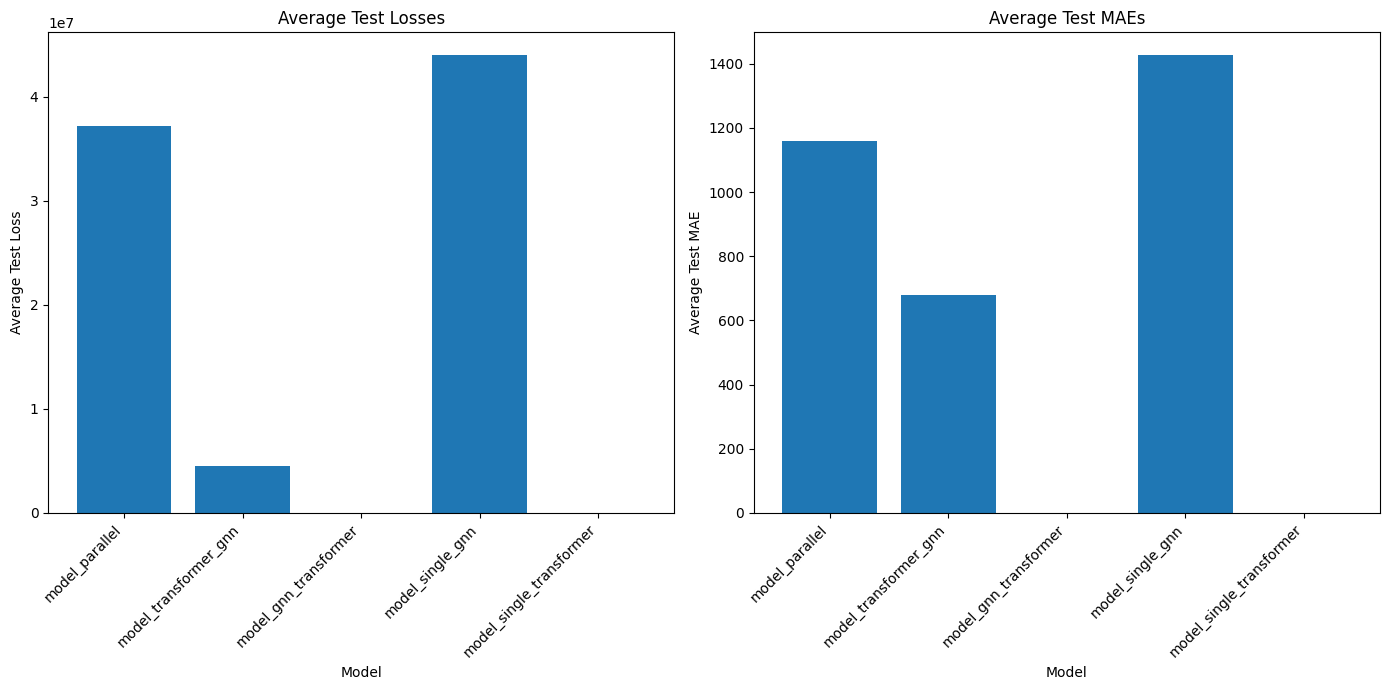

In [42]:

# Plotting average test losses
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
model_names = list(average_test_losses_map.keys())
average_losses = list(average_test_losses_map.values())
plt.bar(range(len(model_names)), average_losses, tick_label=model_names)
plt.xlabel('Model')
plt.ylabel('Average Test Loss')
plt.title('Average Test Losses')
plt.xticks(rotation=45, ha='right')

# Plotting average test MAEs
plt.subplot(1, 2, 2)
average_maes = list(average_test_maes_map.values())
plt.bar(range(len(model_names)), average_maes, tick_label=model_names)
plt.xlabel('Model')
plt.ylabel('Average Test MAE')
plt.title('Average Test MAEs')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()